In [679]:
# uv init
# uv pip install ipykernel #for vscode
# %uv pip install numpy pandas matplotlib seaborn


In [680]:
# data seems to be organize in CSV files without extensions
# with the header line and columns of data. Classical pandas DataFrame format

In [681]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [682]:
def load_data(file_path):
    """
    Load data from a CSV file without an extension and format column names.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: DataFrame containing the loaded data with formatted column names.
    """
    try:
        data = pd.read_csv(file_path, header=0)
        # Remove leading/trailing spaces and replace internal spaces with underscores
        data.columns = [col.strip().replace(' ', '_') for col in data.columns]
        data = data.rename(columns={'y-coordinate': 'y', 'x-coordinate': 'x', 'pressure':'p', 'z-coordinate':'z' ,'x-velocity': 'U', 'y-velocity':'v'})
        data['x_rounded'] = data['x'].round(3)
        data['y_rounded'] = data['y'].round(4)
        data['z_rounded'] = data['z'].round(3)
        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

In [683]:
df = load_data('data/sim 4')  # Replace 'data.csv' with your actual file path

In [684]:
df.columns

Index(['nodenumber', 'x', 'y', 'z', 'p', 'U', 'v', 'turb-kinetic-energy',
       'turb-diss-rate', 'viscosity-turb', 'x_rounded', 'y_rounded',
       'z_rounded'],
      dtype='object')

Number of unique x_rounded values: 129


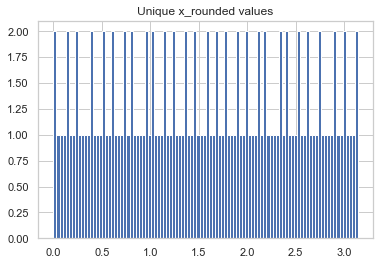

[array([-0.   ,  0.023,  0.047,  0.074,  0.102,  0.131,  0.156,  0.18 ,
        0.203,  0.226,  0.251,  0.278,  0.307,  0.334,  0.36 ,  0.383,
        0.405,  0.427,  0.451,  0.478,  0.505,  0.531,  0.555,  0.578,
        0.599,  0.622,  0.645,  0.671,  0.699,  0.725,  0.749,  0.772,
        0.794,  0.816,  0.839,  0.865,  0.893,  0.919,  0.944,  0.966,
        0.988,  1.01 ,  1.033,  1.059,  1.086,  1.113,  1.138,  1.16 ,
        1.182,  1.204,  1.227,  1.253,  1.28 ,  1.307,  1.332,  1.355,
        1.376,  1.398,  1.421,  1.447,  1.474,  1.501,  1.526,  1.549,
        1.571,  1.593,  1.616,  1.64 ,  1.668,  1.695,  1.72 ,  1.743,
        1.765,  1.787,  1.81 ,  1.834,  1.861,  1.889,  1.914,  1.937,
        1.959,  1.981,  2.004,  2.028,  2.055,  2.083,  2.108,  2.132,
        2.154,  2.175,  2.198,  2.222,  2.249,  2.276,  2.302,  2.326,
        2.348,  2.37 ,  2.392,  2.416,  2.443,  2.47 ,  2.496,  2.52 ,
        2.542,  2.564,  2.586,  2.61 ,  2.636,  2.664,  2.69 ,  2.714,
     

In [685]:

unique_x = np.sort(df['x_rounded'].unique())
print(f"Number of unique x_rounded values: {len(unique_x)}")

plt.hist(unique_x, bins=100)
plt.title("Unique x_rounded values")
plt.show()
print([unique_x])

Number of unique y_rounded values: 5909


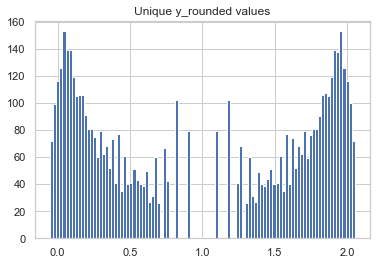

In [686]:
unique_y = df['y_rounded'].unique()
print(f"Number of unique y_rounded values: {len(unique_y)}")

plt.hist(unique_y,bins=100)
plt.title("Unique y_rounded values")
plt.show()

In [687]:
sim_num=4
pi=np.pi
amp=0.05
pi_div=0.5
lam=pi/8
theta_target=pi/pi_div
length=pi
# === User Inputs ===
r = 1.0953    # geometric growth ratio
l1 = 0.00665  # first wall spacing
n = 30     # number of steps per half channel
u_tau=1
nu=float(1/300)
x_target=theta_target*lam*0.5/pi
#for the no interpolation section
periods_number=round(pi/lam)
node_period=round((len(unique_x)-1)/periods_number)
print(node_period)
node_target=round((theta_target*0.5/pi)*node_period)
print(node_target)
node_sel=unique_x[node_target::node_period]
#for the interpolation section
x_sel=list(np.arange(x_target, length  , lam))
x_sel=np.round(x_sel, 5)
print([node_sel])
print([x_sel])


16
16
[array([0.405, 0.794, 1.182, 1.571, 1.959, 2.348, 2.737, 3.142])]
[array([0.3927 , 0.7854 , 1.1781 , 1.5708 , 1.9635 , 2.35619, 2.74889])]


Number of unique z_rounded values: 1


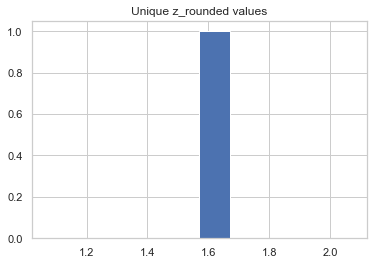

In [688]:
unique_z = df['z_rounded'].unique()
print(f"Number of unique z_rounded values: {len(unique_z)}")

plt.hist(unique_z)
plt.title("Unique z_rounded values")
plt.show()

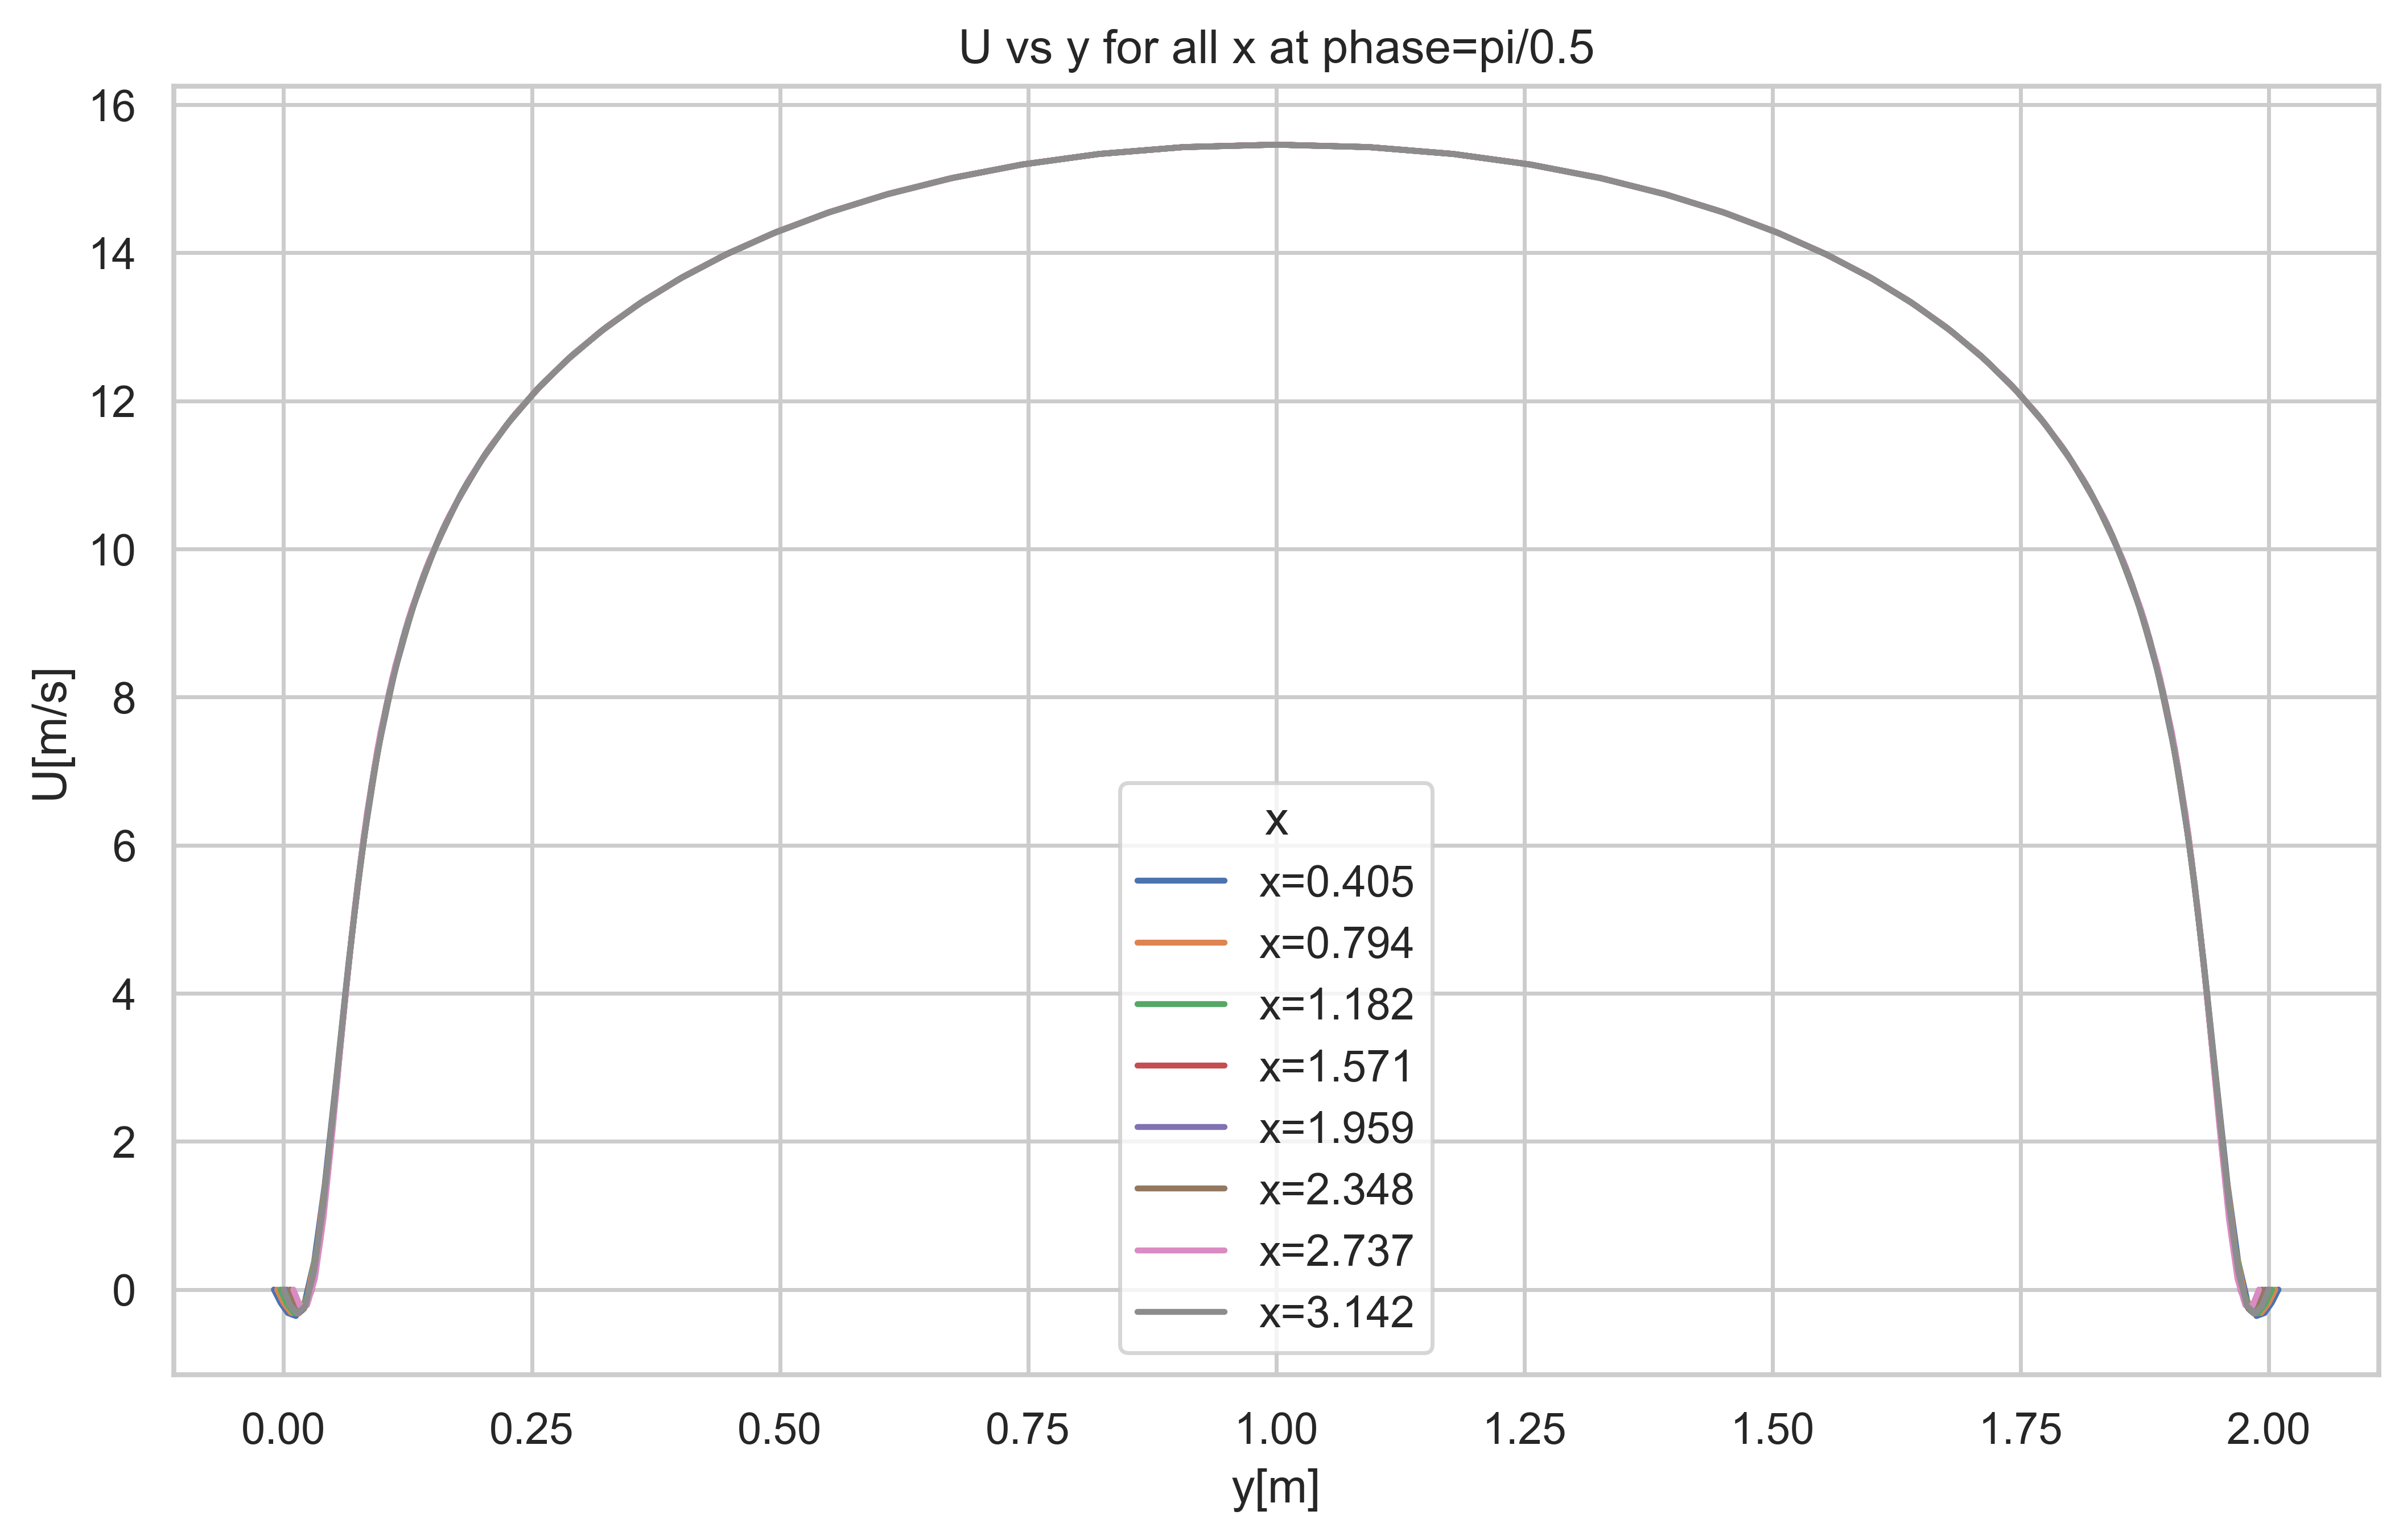

In [689]:
#no interpolatin involved
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6),dpi=500)


for x_val in sorted(node_sel):
    subset = df[df['x_rounded'] == x_val]
    sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val}')

plt.title(f'U vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('U[m/s]')
plt.legend(title='x')
plt.show()

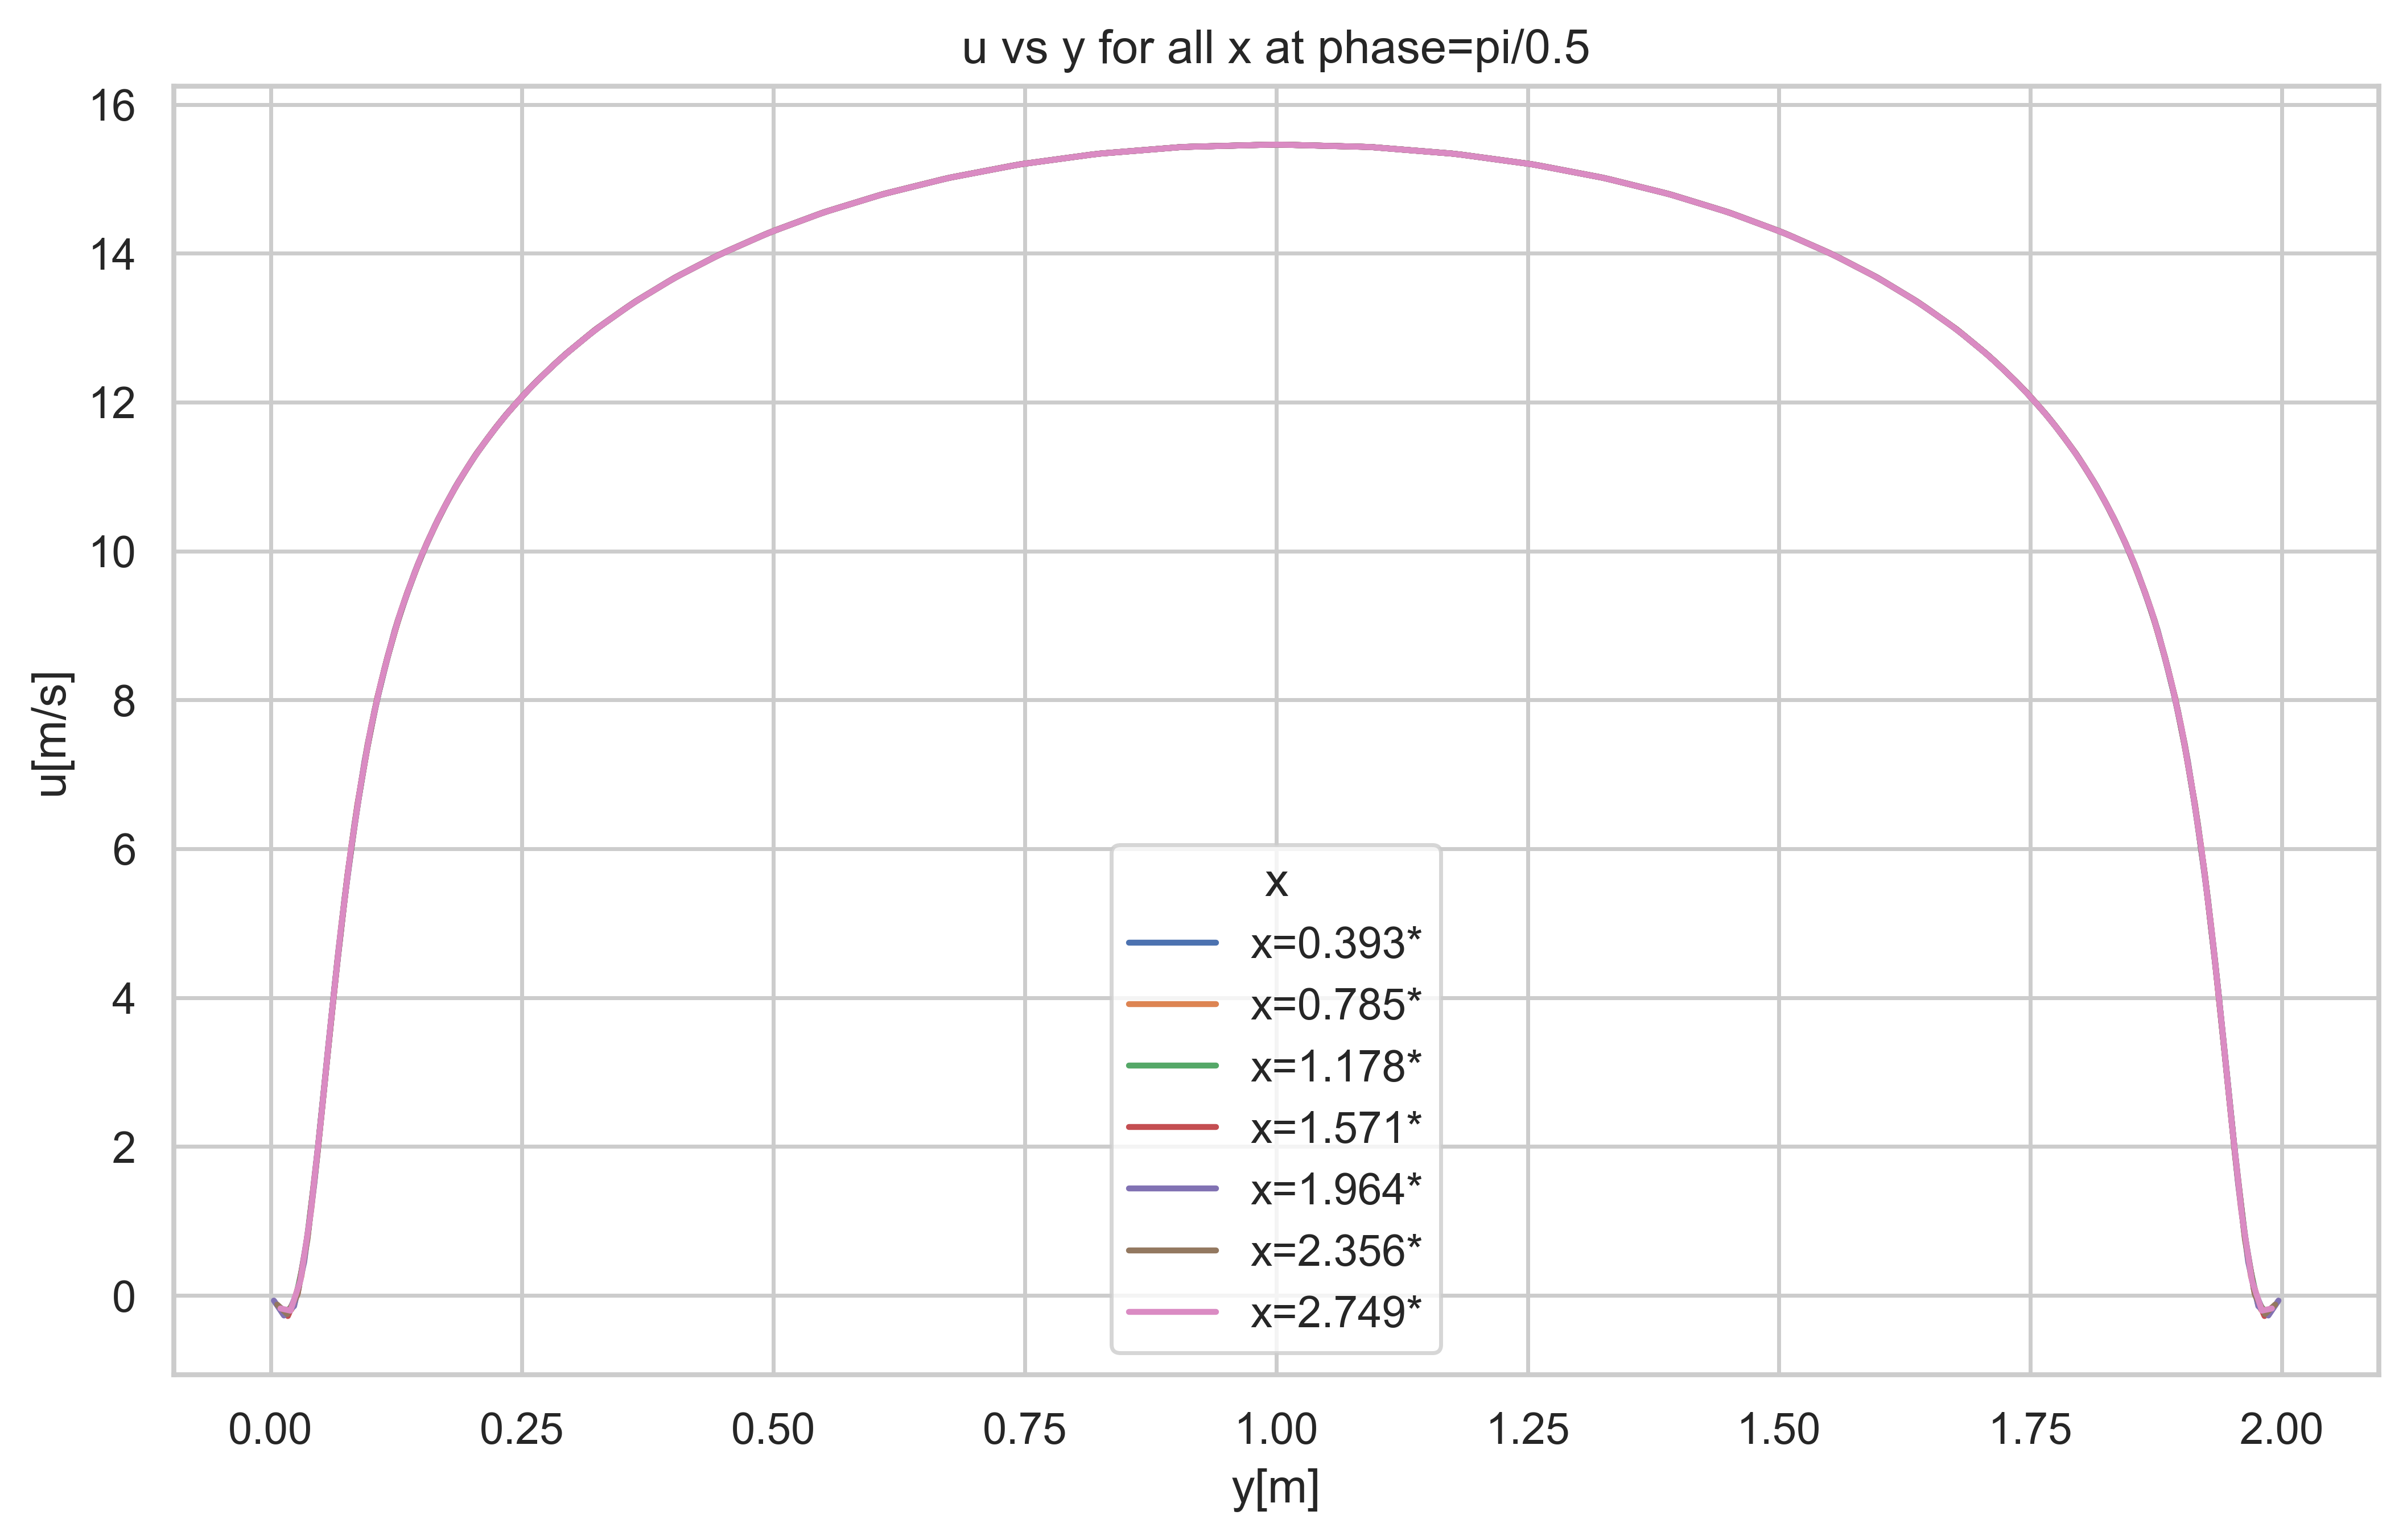

In [690]:
#interpolation in y and then x 
from scipy.interpolate import interp1d
plt.figure(figsize=(10, 6),dpi=500)

for x_val in sorted(x_sel):
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val]
        sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val:.3f}')

    else:
        x_below = unique_x[unique_x < x_val].max(initial=None)
        x_above = unique_x[unique_x > x_val].min(initial=None)

        if x_below is not None and x_above is not None:
            sub_below = df[df['x_rounded'] == x_below].sort_values('y')
            sub_above = df[df['x_rounded'] == x_above].sort_values('y')

            # Build interpolators for U vs y at x_below and x_above
            f_below = interp1d(sub_below['y'], sub_below['U'], bounds_error=False, fill_value=np.nan)
            f_above = interp1d(sub_above['y'], sub_above['U'], bounds_error=False, fill_value=np.nan)

            # Define a common y-grid (e.g. union or fine linspace)
            y_interp = np.linspace(
                max(sub_below['y'].min(), sub_above['y'].min()),
                min(sub_below['y'].max(), sub_above['y'].max()),
                200
            )

            # Interpolate U at both x locations
            U1 = f_below(y_interp)
            U2 = f_above(y_interp)

            # Linear interpolation in x direction
            U_interp = U1 + (U2 - U1) * (x_val - x_below) / (x_above - x_below)

            interp_df = pd.DataFrame({'y': y_interp, 'U': U_interp})
            sns.lineplot(x='y', y='U', data=interp_df, label=f'x={x_val:.3f}*')
plt.title(f'u vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('u[m/s]')
plt.legend(title='x')
plt.grid(True)
plt.show()

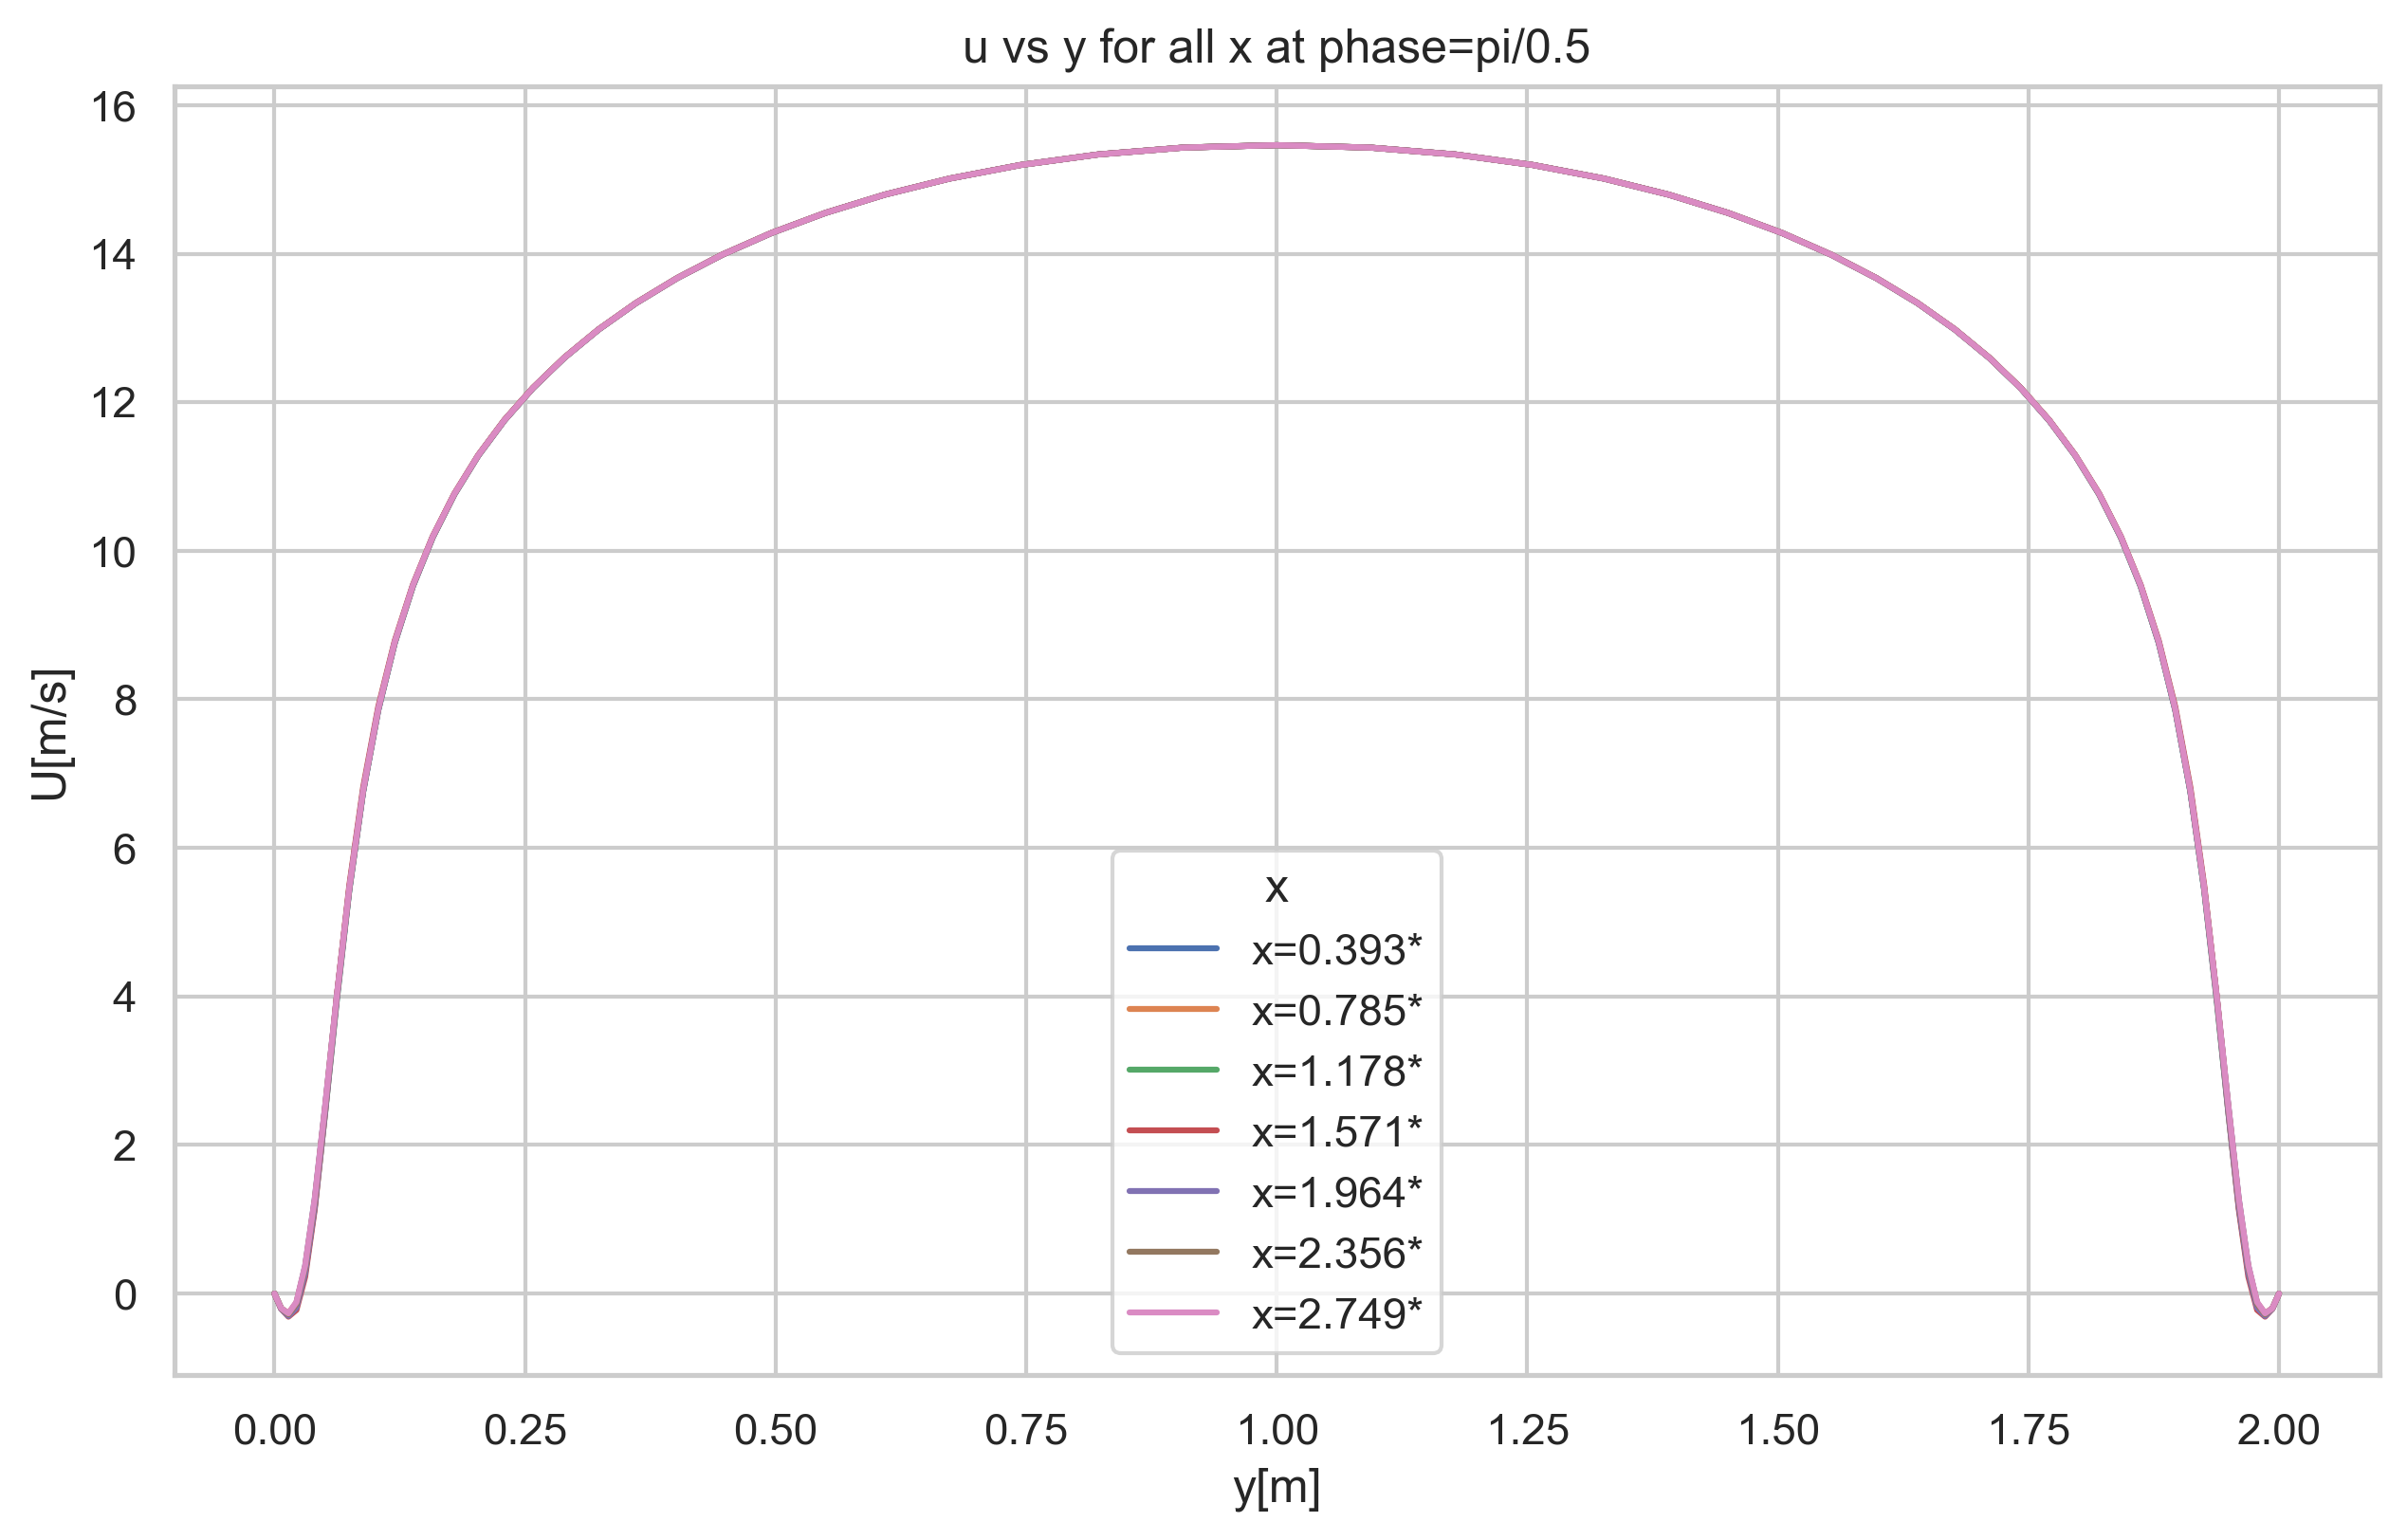

In [691]:
#interpolation in x only by the corresponding node(chosen)
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half + spacing_half[::-1])
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    U_below = sub_below['U']
    U_above = sub_above['U']
    U_interp = U_below + (U_above - U_below) * (x_val - x_below) / (x_above - x_below)

    return pd.DataFrame({'y': y_interp, 'U': U_interp})

x_sel = sorted(x_sel)
unique_x = np.sort(df['x_rounded'].unique())

# === Plotting ===
plt.figure(figsize=(10, 6), dpi=300)
for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].sort_values('y')
        sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val:.3f}')
    else:
        interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
        if interp_df is not None:
            sns.lineplot(x='y', y='U', data=interp_df, label=f'x={x_val:.3f}*')

plt.title(f'u vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('U[m/s]')
plt.grid(True)
plt.legend(title='x')
# Target folder name (must already exist)
folder = f"sim_{sim_num}_figs"

# Ensure the folder exists (optional but safe)
os.makedirs(folder, exist_ok=True)

# Create the full filename with desired name, saved into that folder
filename = os.path.join(folder, f'Uvsy_sim_{sim_num}_phase=piby{pi_div}.png')

# Save the figure
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

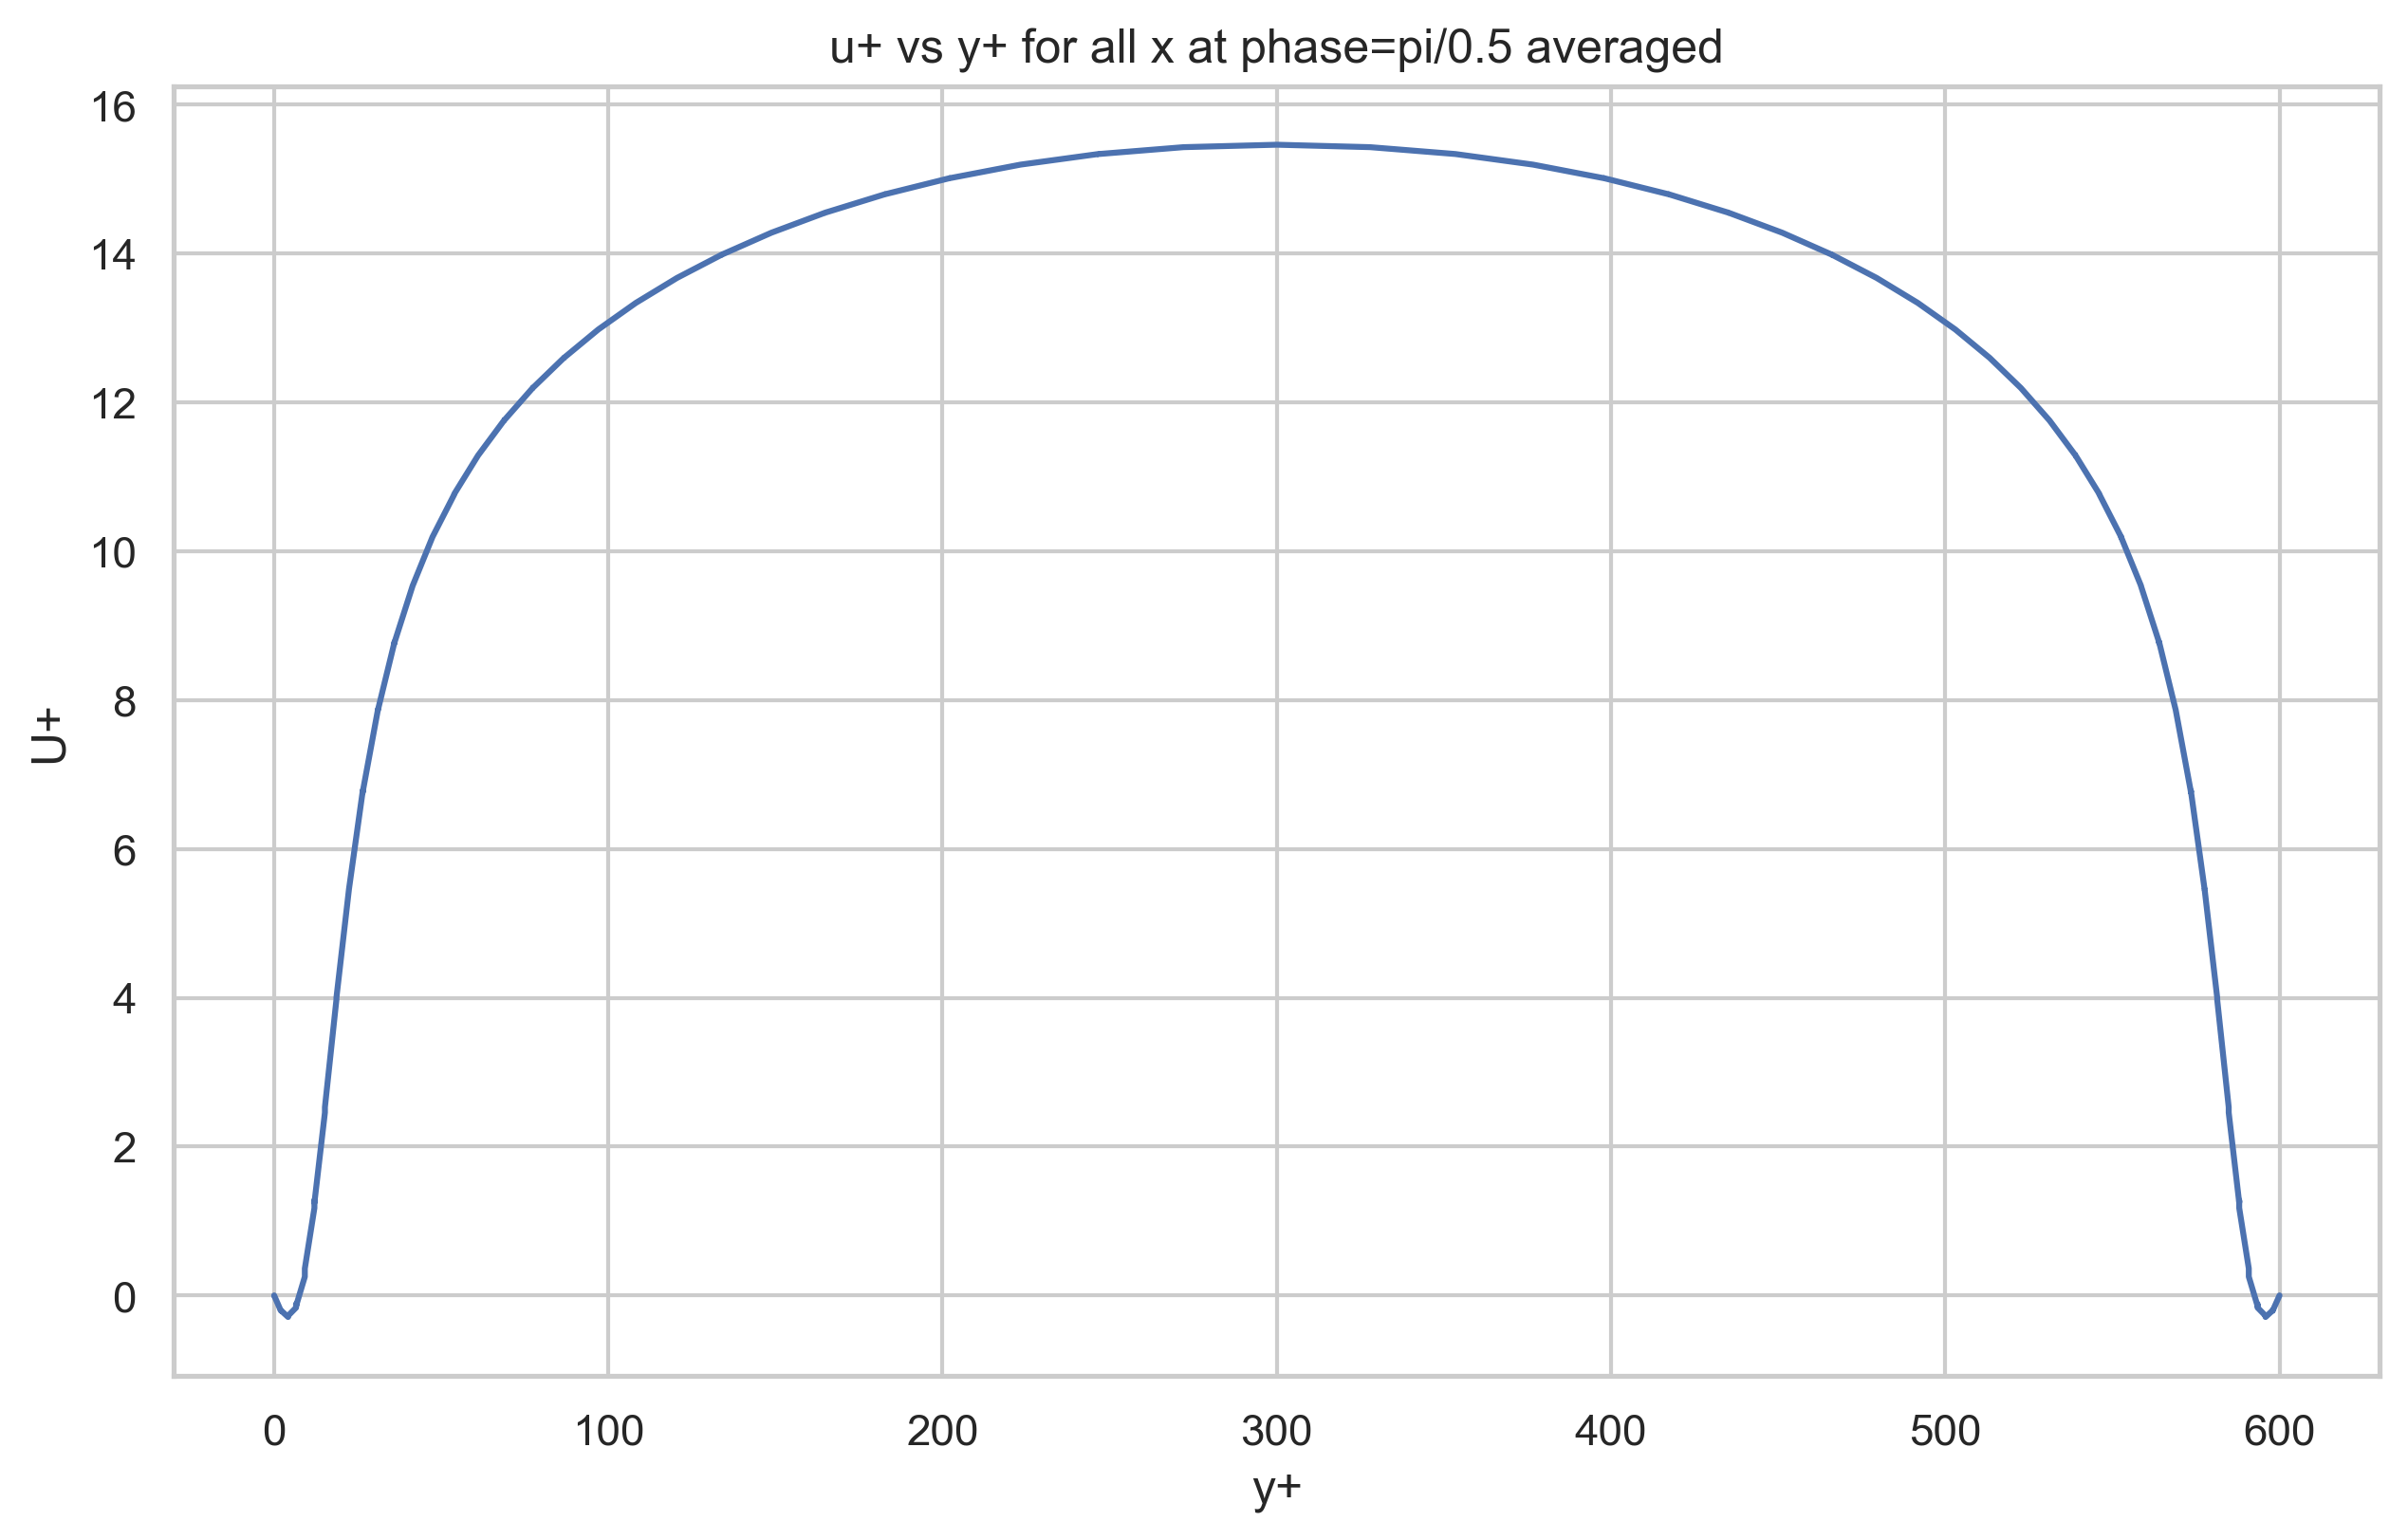

In [692]:

#interpolation in x only by the corresponding node(chosen) plus phase averaged
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half + spacing_half[::-1])
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)
    y_plus=y_interp*u_tau/nu

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    U_below = sub_below['U']
    U_above = sub_above['U']
    U_interp = U_below + (U_above - U_below) * (x_val - x_below) / (x_above - x_below)
    U_plus=U_interp/u_tau

    return pd.DataFrame({'y_plus': y_plus, 'U_plus': U_plus})

#plotting average
all_data = []

for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].copy()
        subset['y_plus'] = subset['y'] * u_tau / nu
        subset['U_plus'] = subset['U'] / u_tau
        subset = subset[['y_plus', 'U_plus']]
    else:
        subset = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
    if subset is not None:
        subset['y_plus'] = subset['y_plus'].round(3)
        all_data.append(subset)

# Concatenate and average
combined_df = pd.concat(all_data)
avg_df = combined_df.groupby('y_plus', as_index=False)['U_plus'].mean()
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=avg_df, x='y_plus', y='U_plus')
# === Plotting ===
#plt.figure(figsize=(10, 6), dpi=300)
#for x_val in x_sel:
 #   if x_val in unique_x:
  #      subset = df[df['x_rounded'] == x_val].sort_values('y')
   #     sns.lineplot(x='y_plus', y='U_plus', data=subset, label=f'x={x_val:.3f}')
    #else:
     #   interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
      #  if interp_df is not None:
       #     sns.lineplot(x='y_plus', y='U_plus', data=interp_df, label=f'x={x_val:.3f}*')


plt.title(f'u+ vs y+ for all x at phase=pi/{pi_div} averaged')
plt.xlabel('y+')
plt.ylabel('U+')
plt.grid(True)
plt.show()
avg_df.to_csv(f'csv/avg_profile_sim_{sim_num}_phase_piby{pi_div}.csv', index=False)

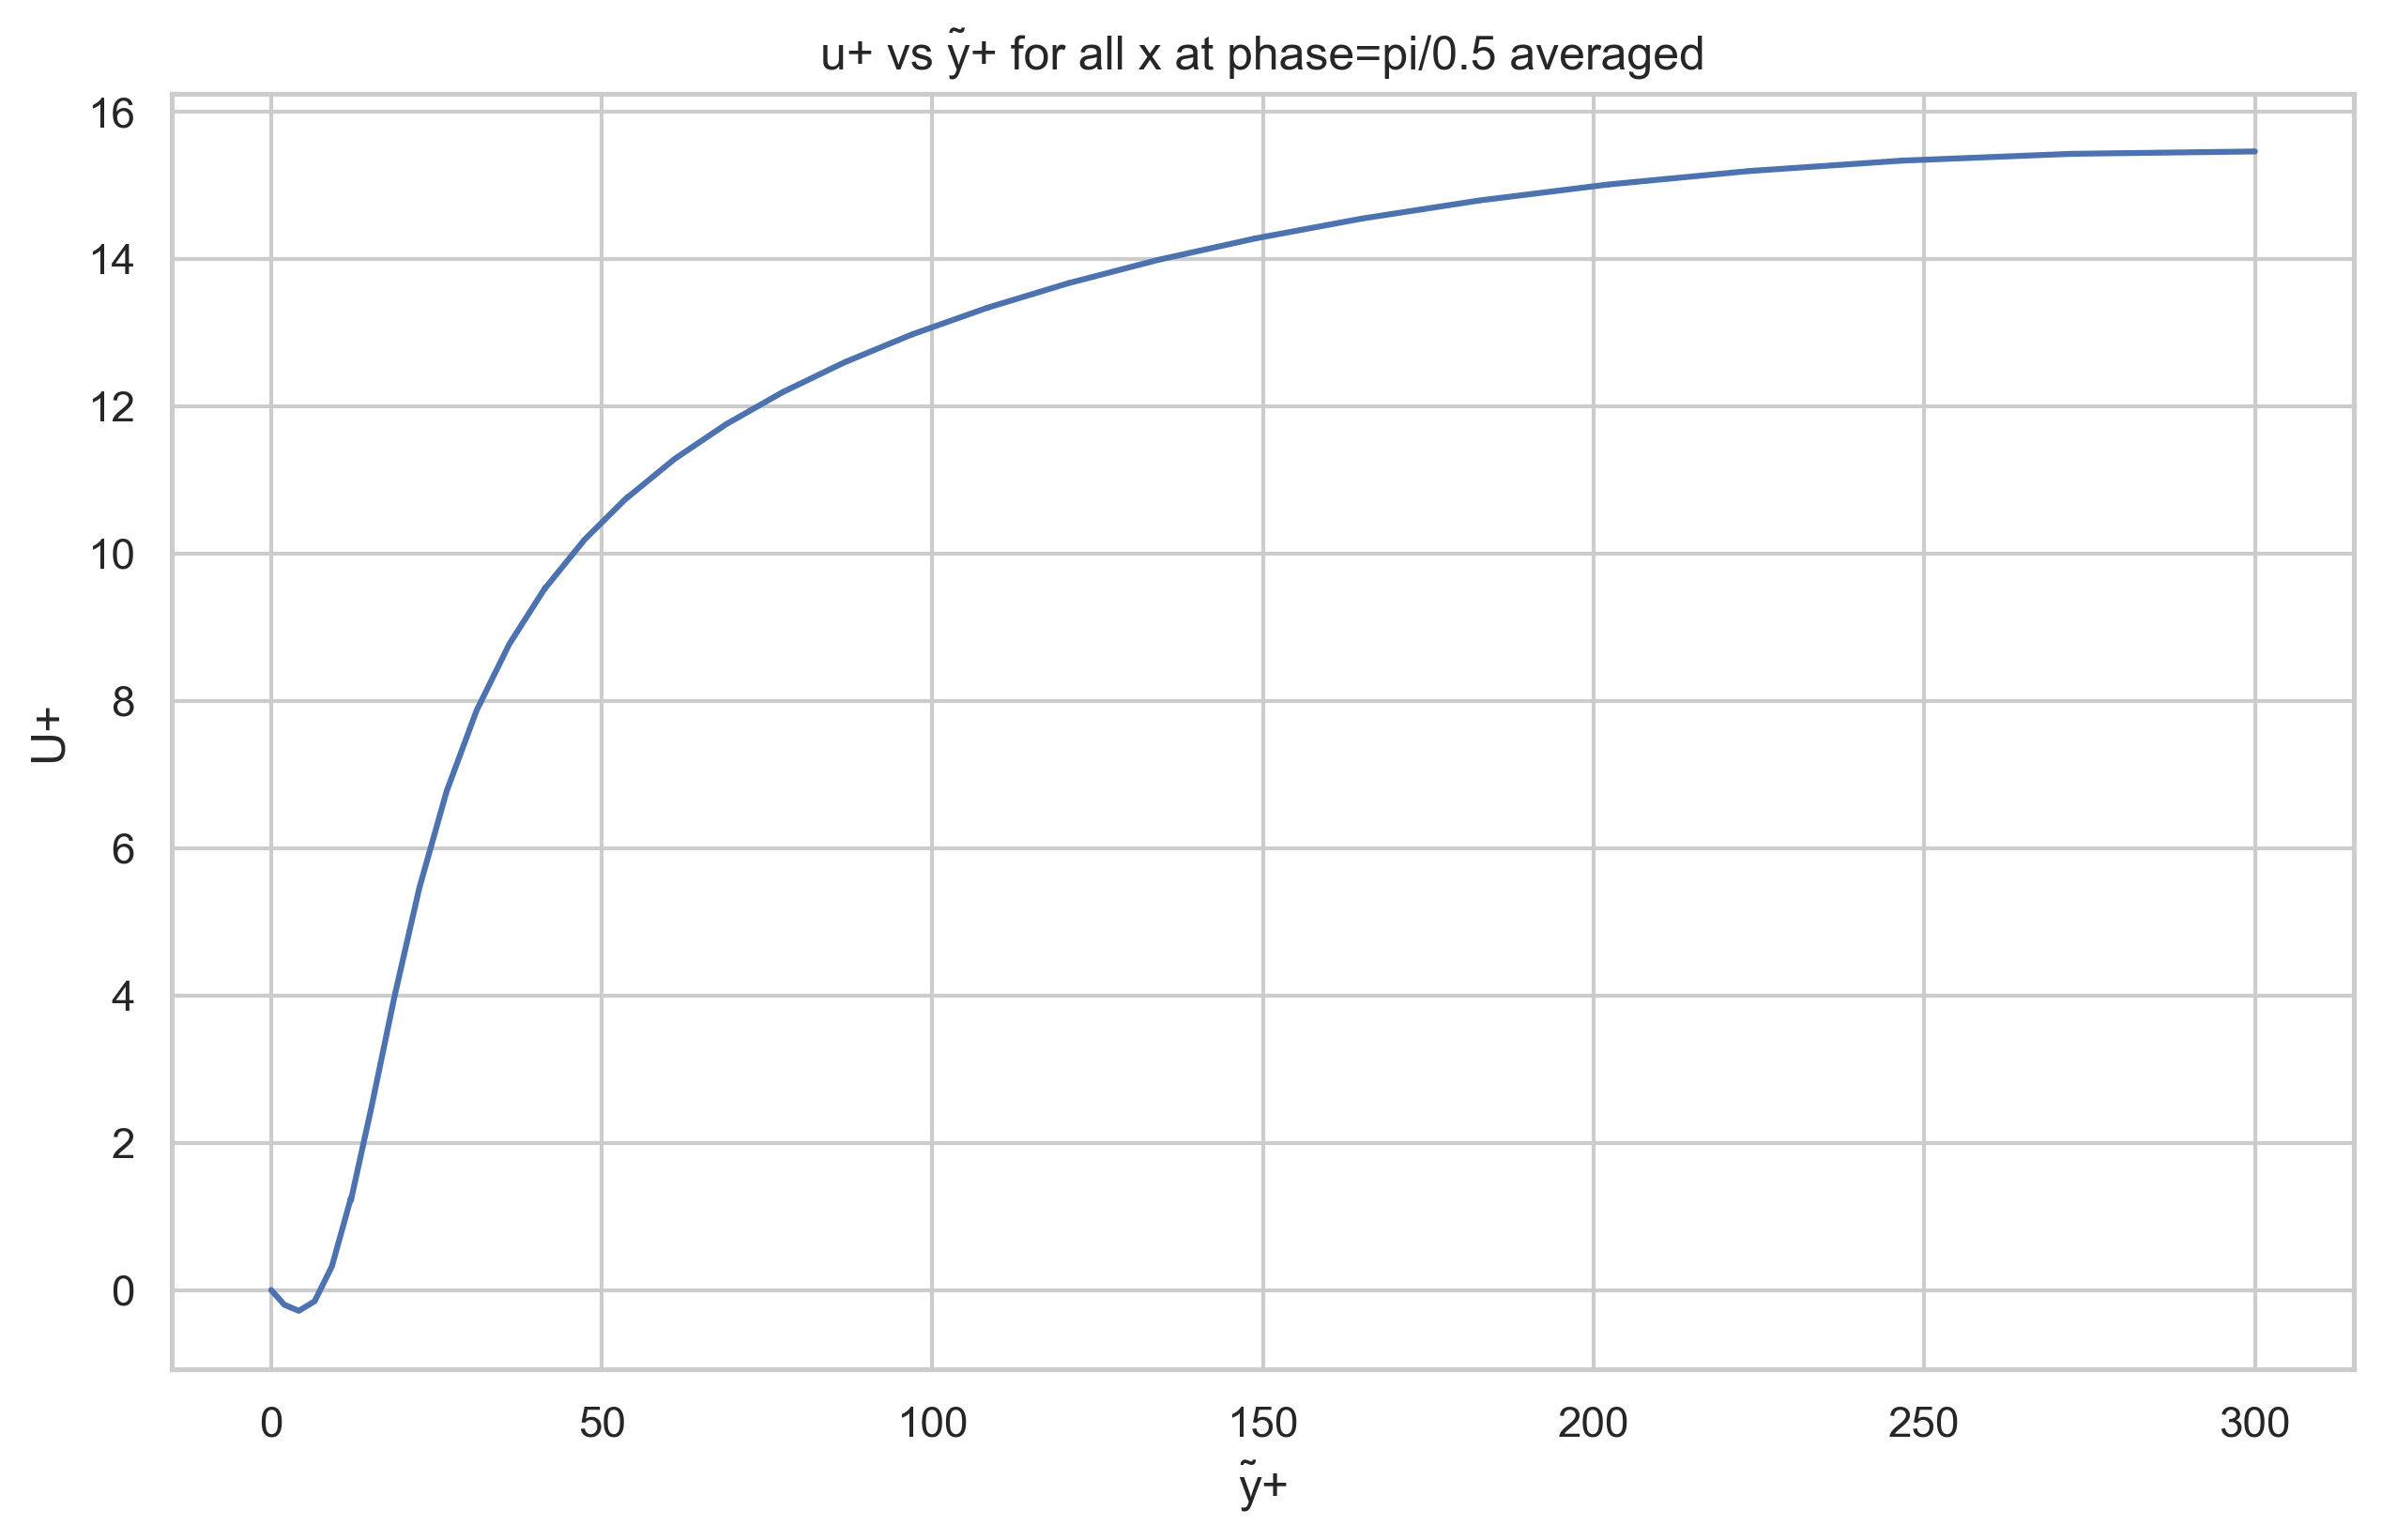

In [693]:

#interpolation in x only by the corresponding node(chosen) plus wavy phase averaged
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half )
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)/2
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)
    y_plus=y_interp*u_tau/nu
    y_plus_wavy=(y_interp-y_min)*u_tau/nu

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    U_below = sub_below['U'].iloc[:n+1]
    U_above = sub_above['U'].iloc[:n+1]
    U_interp = U_below + (U_above - U_below) * (x_val - x_below) / (x_above - x_below)
    U_plus=U_interp/u_tau

    return pd.DataFrame({'y_plus_wavy': y_plus_wavy, 'U_plus': U_plus})

#plotting average
all_data = []

for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].copy()
        subset['y_plus_wavy'] = (subset['y']+0.05 * np.sin(16 * x_val))* u_tau / nu
        subset['U_plus'] = subset['U'] / u_tau
        subset = subset[['y_plus_wavy', 'U_plus']]
    else:
        subset = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
    if subset is not None:
        subset['y_plus_wavy'] = subset['y_plus_wavy'].round(3)
        all_data.append(subset)

# Concatenate and average
combined_df = pd.concat(all_data)
avg_df = combined_df.groupby('y_plus_wavy', as_index=False)['U_plus'].mean()
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=avg_df, x='y_plus_wavy', y='U_plus')
# === Plotting ===
#plt.figure(figsize=(10, 6), dpi=300)
#for x_val in x_sel:
 #   if x_val in unique_x:
  #      subset = df[df['x_rounded'] == x_val].sort_values('y')
   #     sns.lineplot(x='y_plus', y='U_plus', data=subset, label=f'x={x_val:.3f}')
    #else:
     #   interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
      #  if interp_df is not None:
       #     sns.lineplot(x='y_plus', y='U_plus', data=interp_df, label=f'x={x_val:.3f}*')

avg_df.to_csv(f'csv/avg_profile_wavy_sim_{sim_num}_phase_piby{pi_div}.csv', index=False)
plt.title(f'u+ vs y\u0303+ for all x at phase=pi/{pi_div} averaged')
plt.xlabel('y\u0303+')
plt.ylabel('U+')
plt.grid(True)
plt.show()


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0, flags=flags)


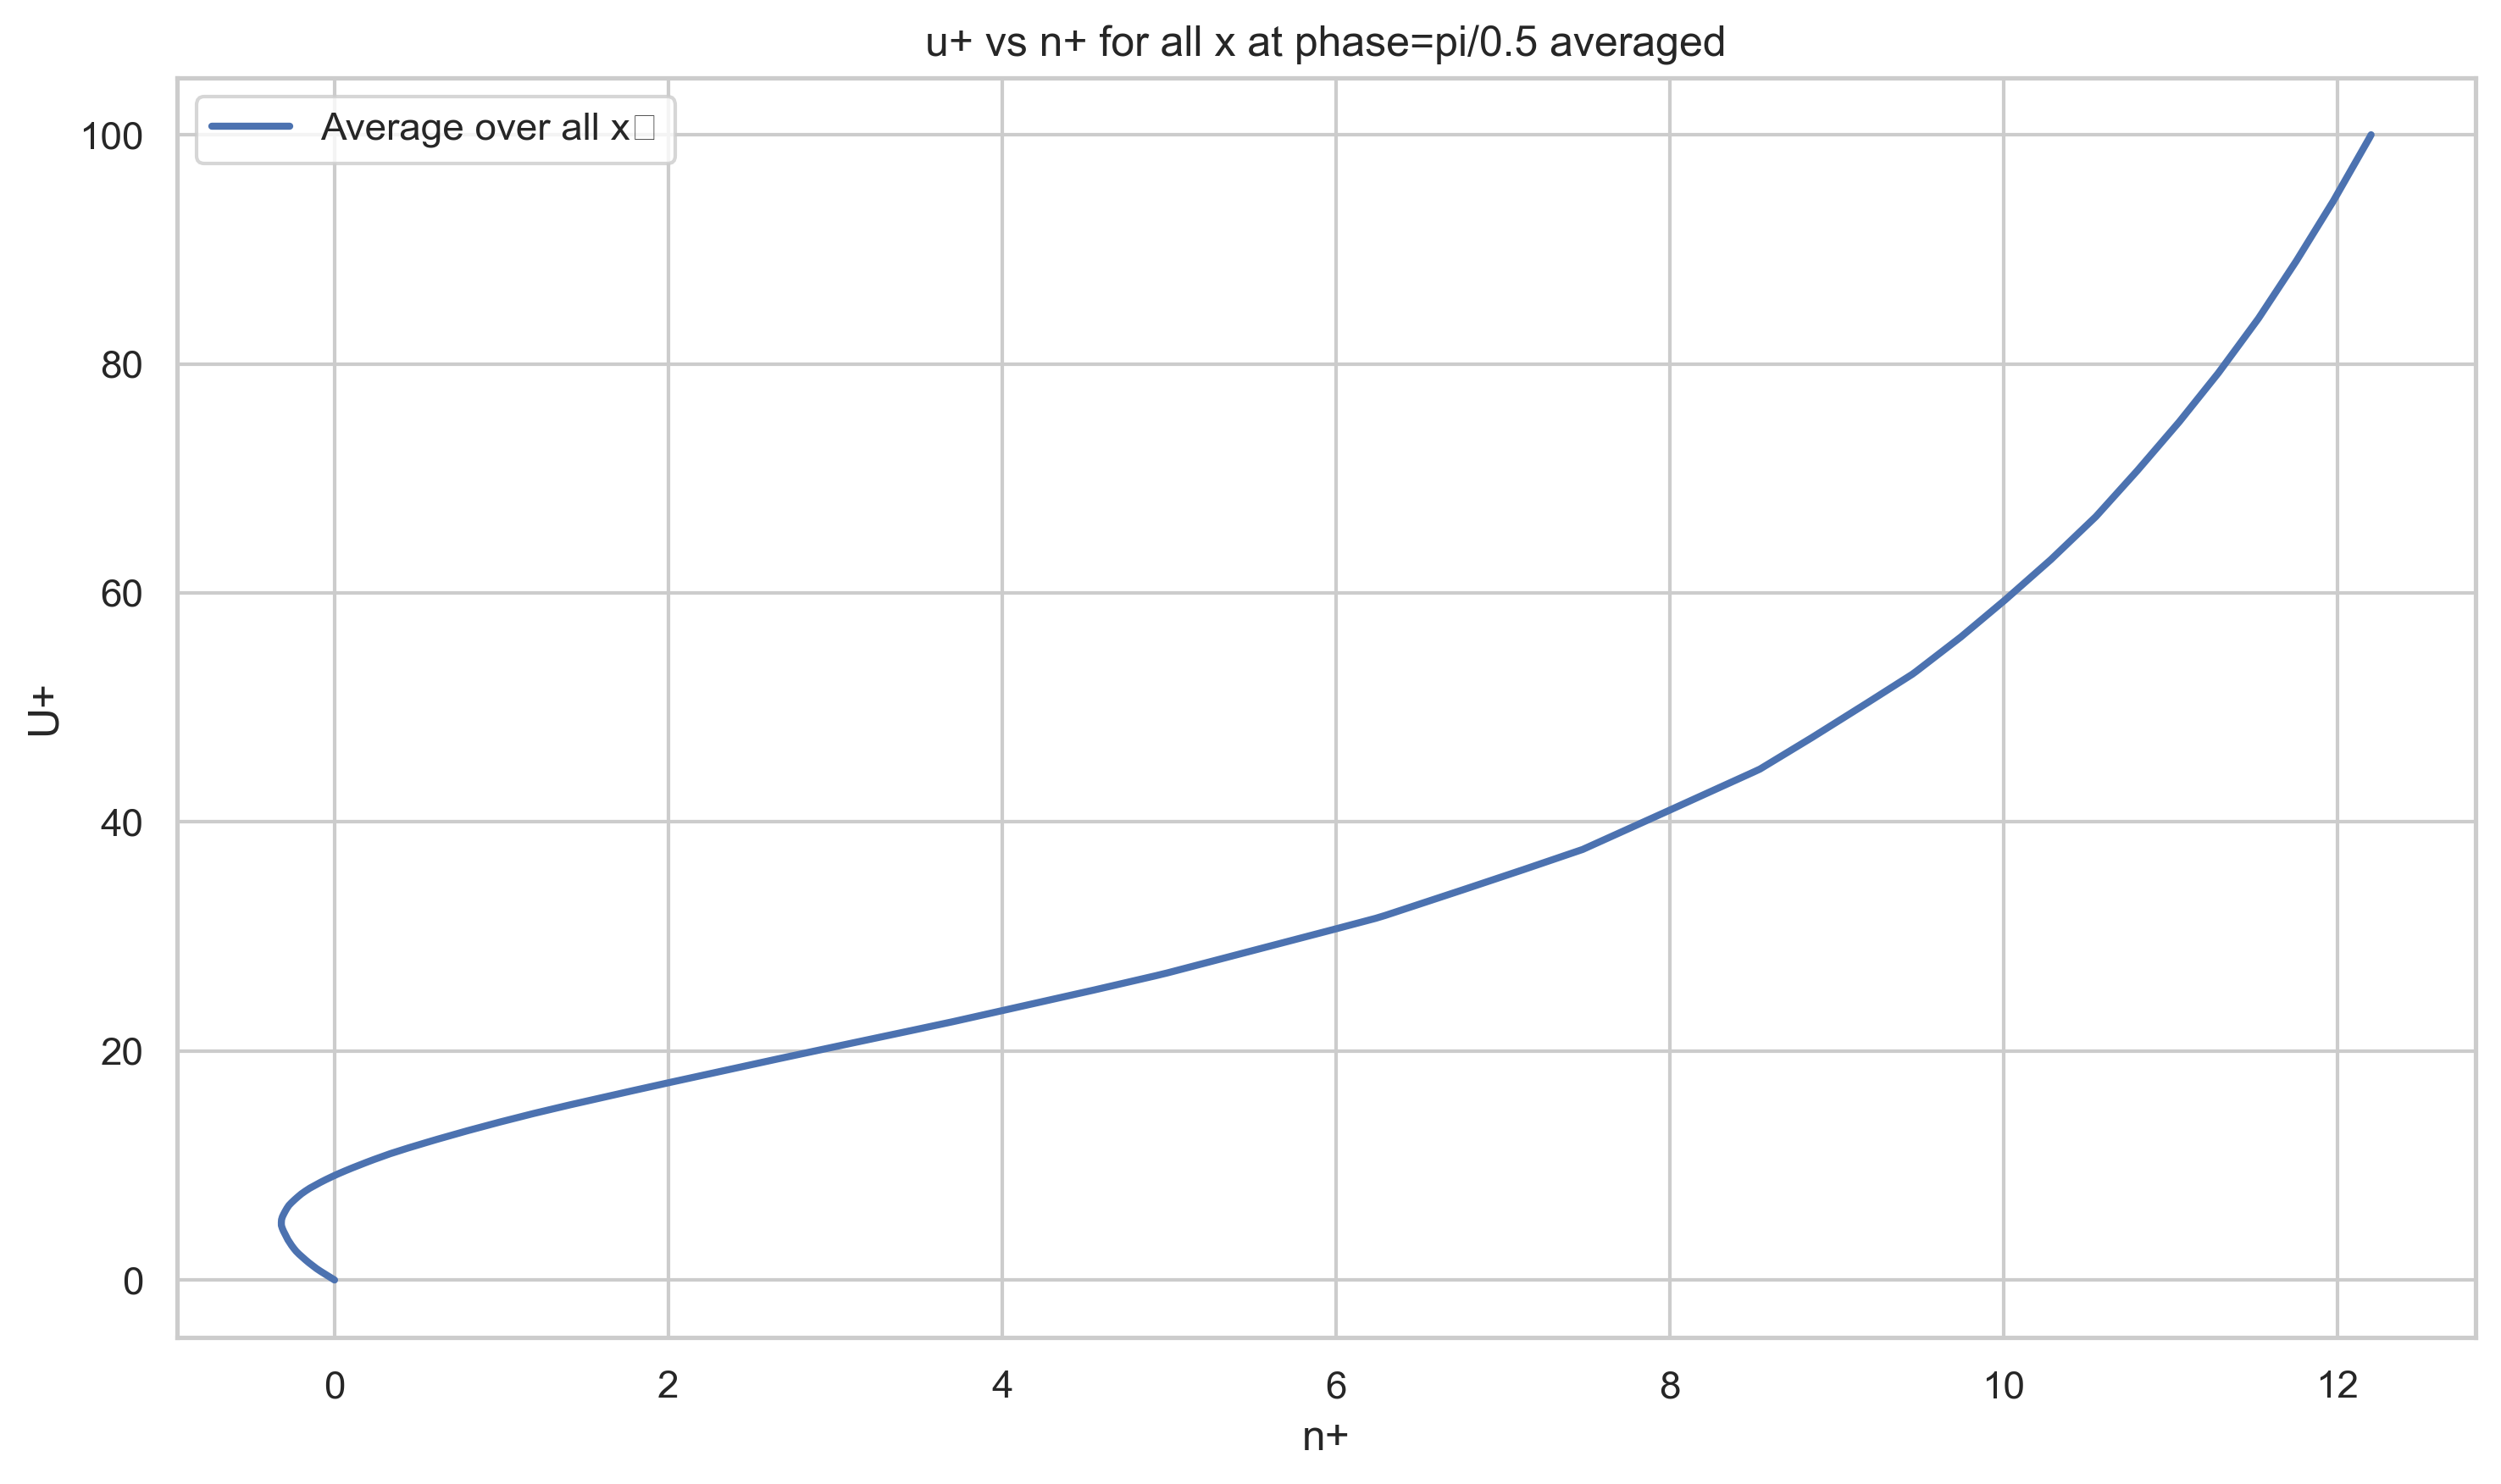

In [694]:
# --- Normal-to-wall profiles: U+ vs n+ (no-slip at wall, robust near wall) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

sns.set(style="whitegrid")

# === Inputs (you already have these) ===
# df: DataFrame with columns: x (or x_rounded), y, U
# u_tau: friction velocity
# nu: kinematic viscosity
# x_sel: list of x locations
XCOL = 'x' if 'x' in df.columns else 'x_rounded'
YCOL = 'y'
UCOL = 'U'

# ---- Wall geometry ----
def y_wall(x):
    return -0.05 * np.sin(16.0 * x)

def dy_wall_dx(x):
    return -0.8 * np.cos(16.0 * x)

def unit_normal_into_fluid(x):
    m = dy_wall_dx(x)
    nx, ny = -m, 1.0
    s = np.hypot(nx, ny)
    return nx / s, ny / s

# ---- Interpolators ----
def make_U_interpolators(df, xcol=XCOL, ycol=YCOL, ucol=UCOL):
    pts = np.column_stack((df[xcol].values, df[ycol].values))
    vals = df[ucol].values
    lin = LinearNDInterpolator(pts, vals, fill_value=np.nan)
    near = NearestNDInterpolator(pts, vals)
    return lin, near

lin_interp, near_interp = make_U_interpolators(df)

# ---- Profile builder ----
def normal_profile(x0, lin_interp, near_interp, u_tau, nu,
                   nplus_max=200, n_points=250, nplus_min=0.8,
                   fallback_band=5.0):
    y0 = y_wall(x0)
    nx, ny = unit_normal_into_fluid(x0)

    # Geometric spacing
    r = 1.06
    steps = r**np.arange(n_points)
    steps = steps / steps.sum() * (nplus_max - nplus_min)
    n_plus = nplus_min + np.cumsum(steps)

    s = n_plus * (nu / u_tau)
    xs = x0 + s * nx
    ys = y0 + s * ny

    U_lin = lin_interp(xs, ys)
    U_near = near_interp(xs, ys)
    use_near = np.isnan(U_lin) & (n_plus <= (nplus_min + fallback_band))
    U_vals = np.where(use_near, U_near, U_lin)

    ok = ~np.isnan(U_vals)
    n_plus_ok = n_plus[ok]
    U_plus_ok = U_vals[ok] / u_tau

    # Anchor at wall
    n_plus_full = np.concatenate(([0.0], n_plus_ok))
    U_plus_full = np.concatenate(([0.0], U_plus_ok))

    return pd.DataFrame({"U_plus": U_plus_full,"n_plus": n_plus_full, })

# ---- Collect profiles for all x0 ----
profiles = []
for x0 in sorted(x_sel):
    prof = normal_profile(x0, lin_interp, near_interp, u_tau, nu)
    profiles.append(prof)

# ---- Average onto common n+ grid ----
common_nplus = np.linspace(0, 100, 400)
stack = []
for prof in profiles:
    n = prof["n_plus"].values
    u = prof["U_plus"].values
    order = np.argsort(n)
    n_sorted, u_sorted = n[order], u[order]
    u_interp = np.interp(common_nplus, n_sorted, u_sorted, left=np.nan, right=np.nan)
    stack.append(u_interp)

stack_arr = np.vstack(stack)
avg_Uplus = np.nanmean(stack_arr, axis=0)

# ---- Plot ----
avg_df.to_csv(f'csv/avg_normal_profile_wavy_sim_{sim_num}_phase_piby{pi_div}.csv', index=False)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(avg_Uplus, common_nplus, linewidth=2, label="Average over all x₀")
plt.xlabel("n+")
plt.ylabel("U+")
plt.title(f"u+ vs n+ for all x at phase=pi/{pi_div} averaged")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



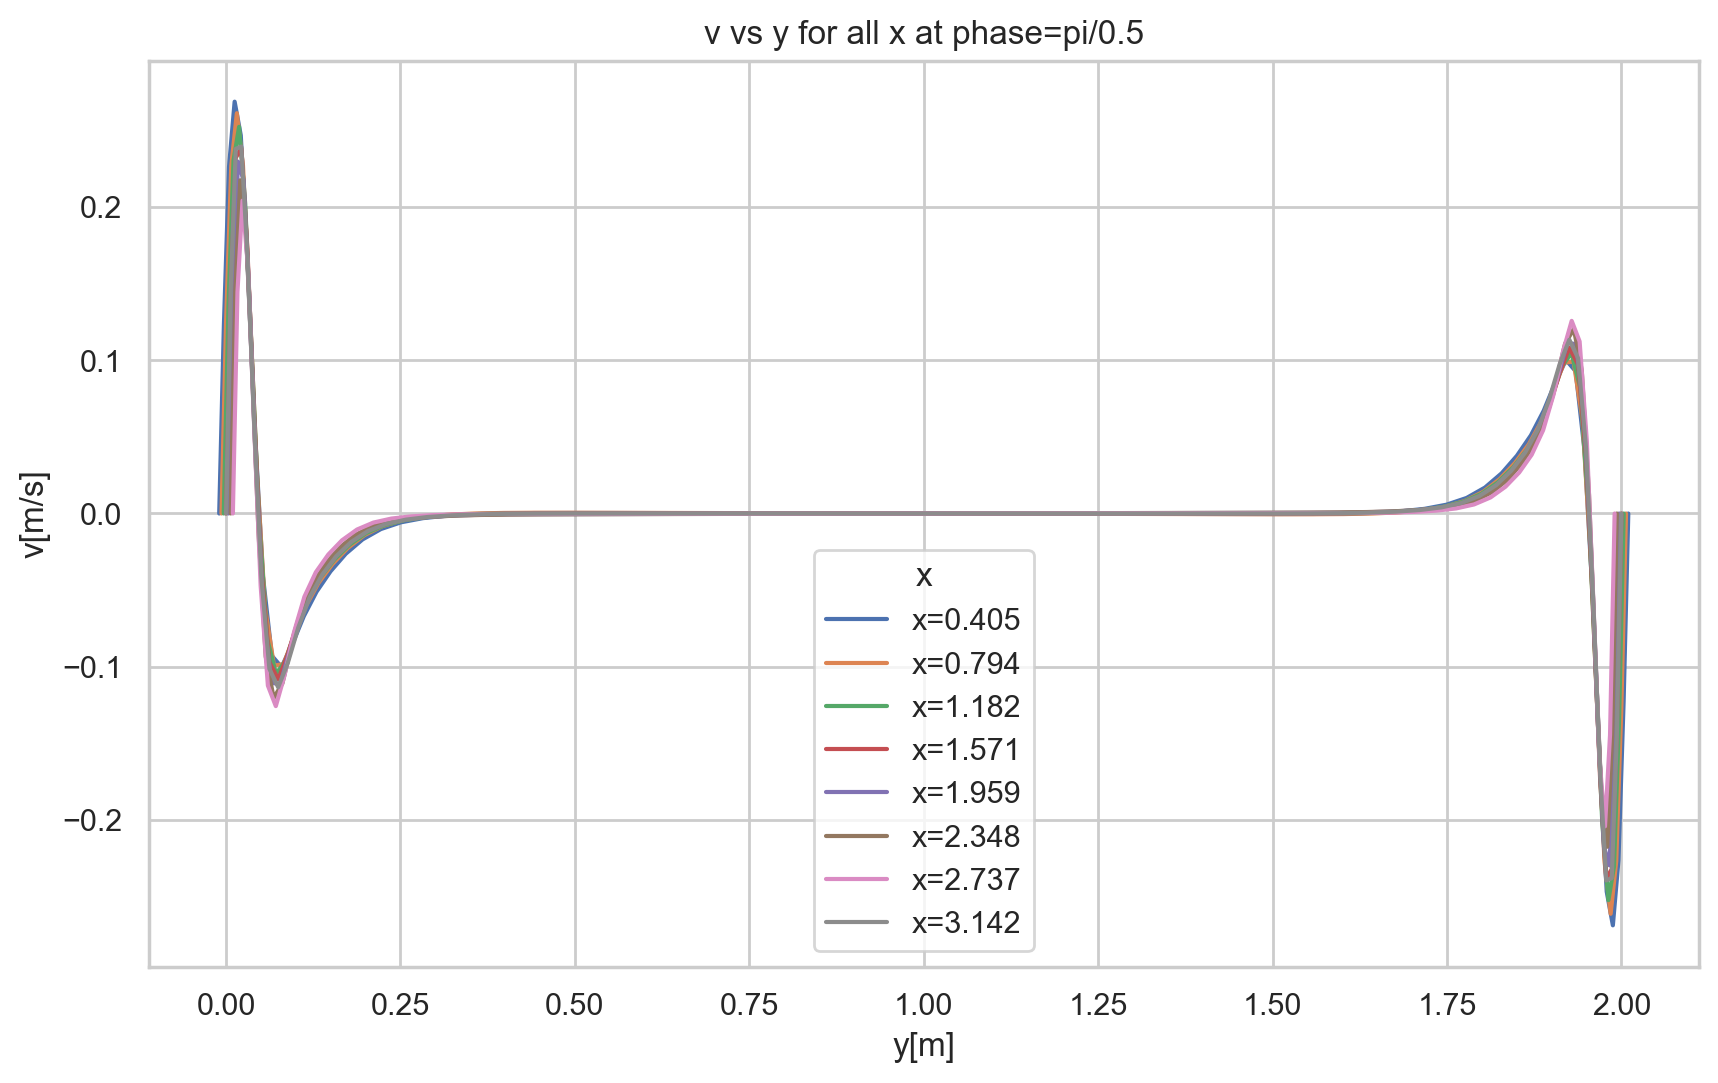

In [695]:
#no interpolatin involved
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6),dpi=200)


for x_val in sorted(node_sel):
    subset = df[df['x_rounded'] == x_val]
    sns.lineplot(x='y', y='v', data=subset, label=f'x={x_val}')

plt.title(f'v vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('v[m/s]')
plt.legend(title='x')
plt.show()

In [696]:
#interpolation in x only by the corresponding node(chosen)
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half + spacing_half[::-1])
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    v_below = sub_below['v']
    v_above = sub_above['v']
    v_interp = v_below + (v_above - v_below) * (x_val - x_below) / (x_above - x_below)

    return pd.DataFrame({'y': y_interp, 'v': v_interp})


# === Plotting ===
plt.figure(figsize=(10, 6), dpi=300)
for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].sort_values('y')
        sns.lineplot(x='y', y='v', data=subset, label=f'x={x_val:.3f}')
    else:
        interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
        if interp_df is not None:
            sns.lineplot(x='y', y='v', data=interp_df, label=f'x={x_val:.3f}*')

plt.title(f'u vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('v[m/s]')
plt.grid(True)
plt.legend(title='x')
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 3000x1800 with 0 Axes>

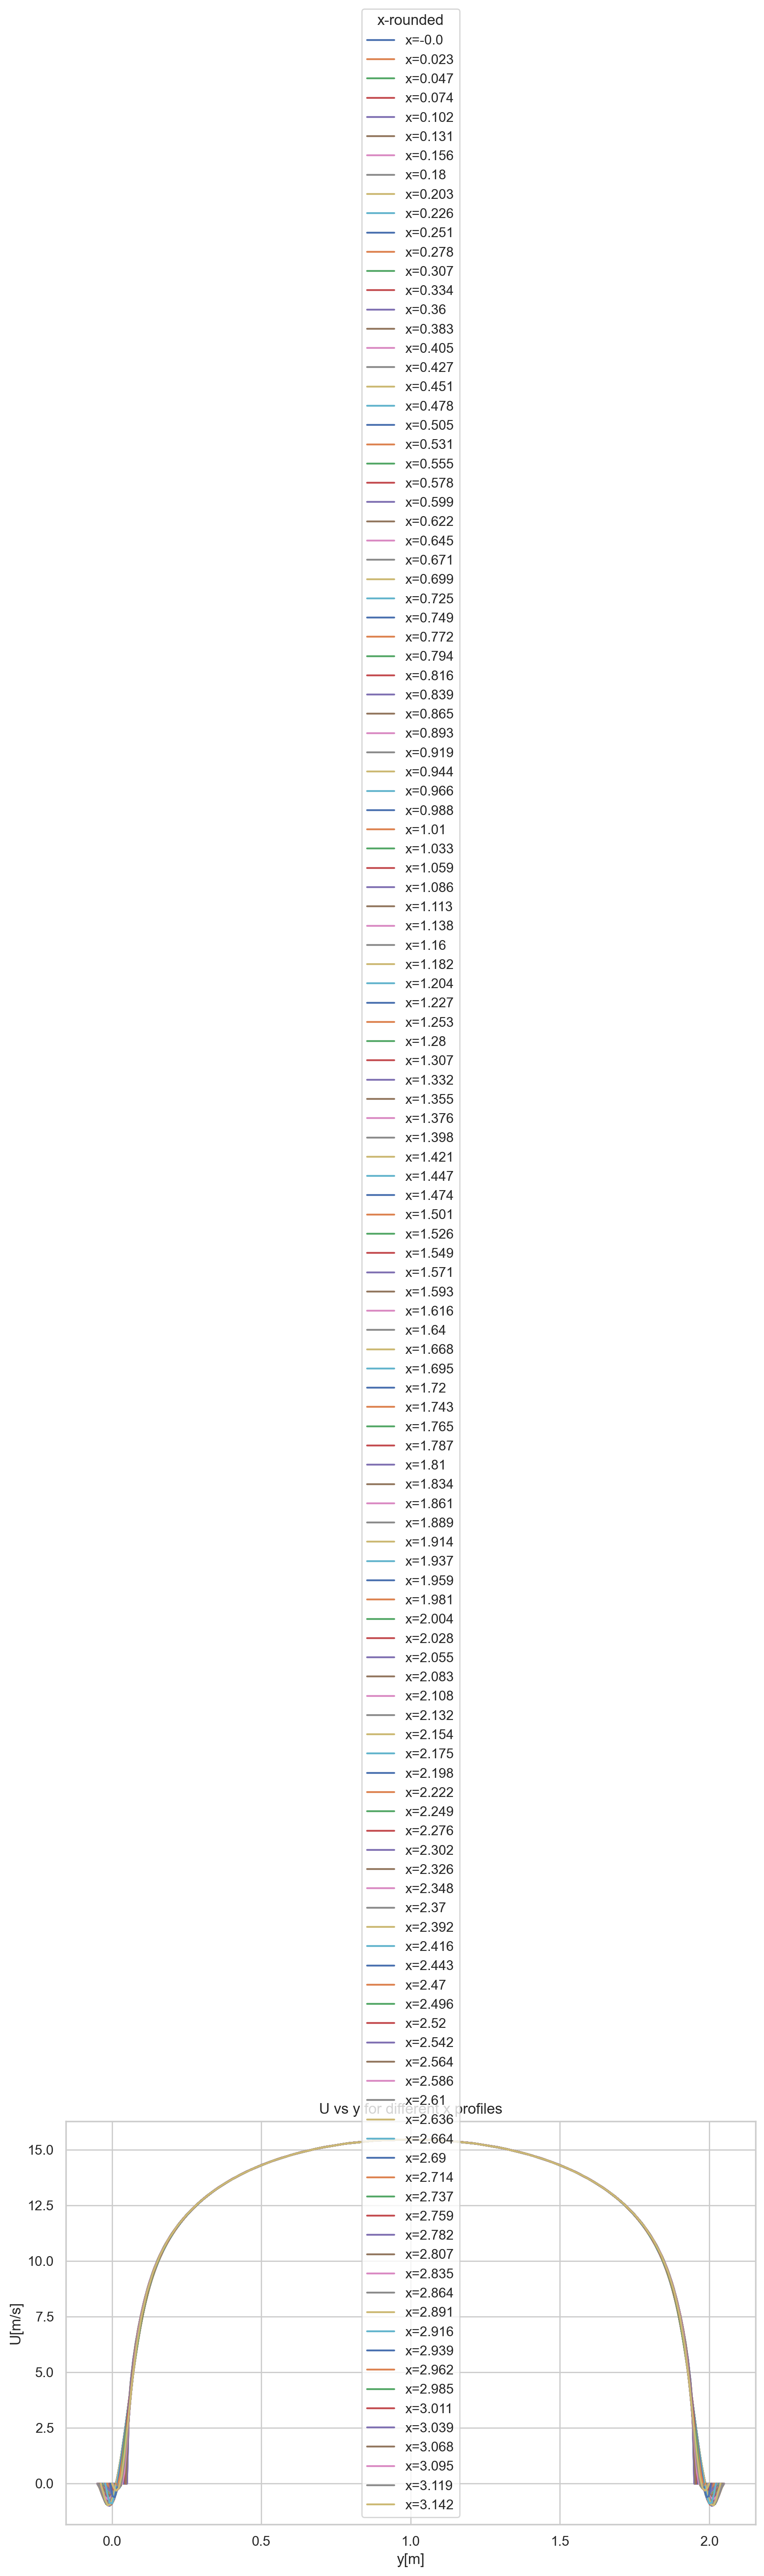

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6),dpi=200)


# Group by rounded x to 1 decimal place and plot U vs y for each group
for x_val in sorted(df['x_rounded'].unique()):
    subset = df[df['x_rounded'] == x_val]
    sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val}')

plt.title('U vs y for different x profiles')
plt.xlabel('y[m]')
plt.ylabel('U[m/s]')
plt.legend(title='x-rounded')
plt.show()

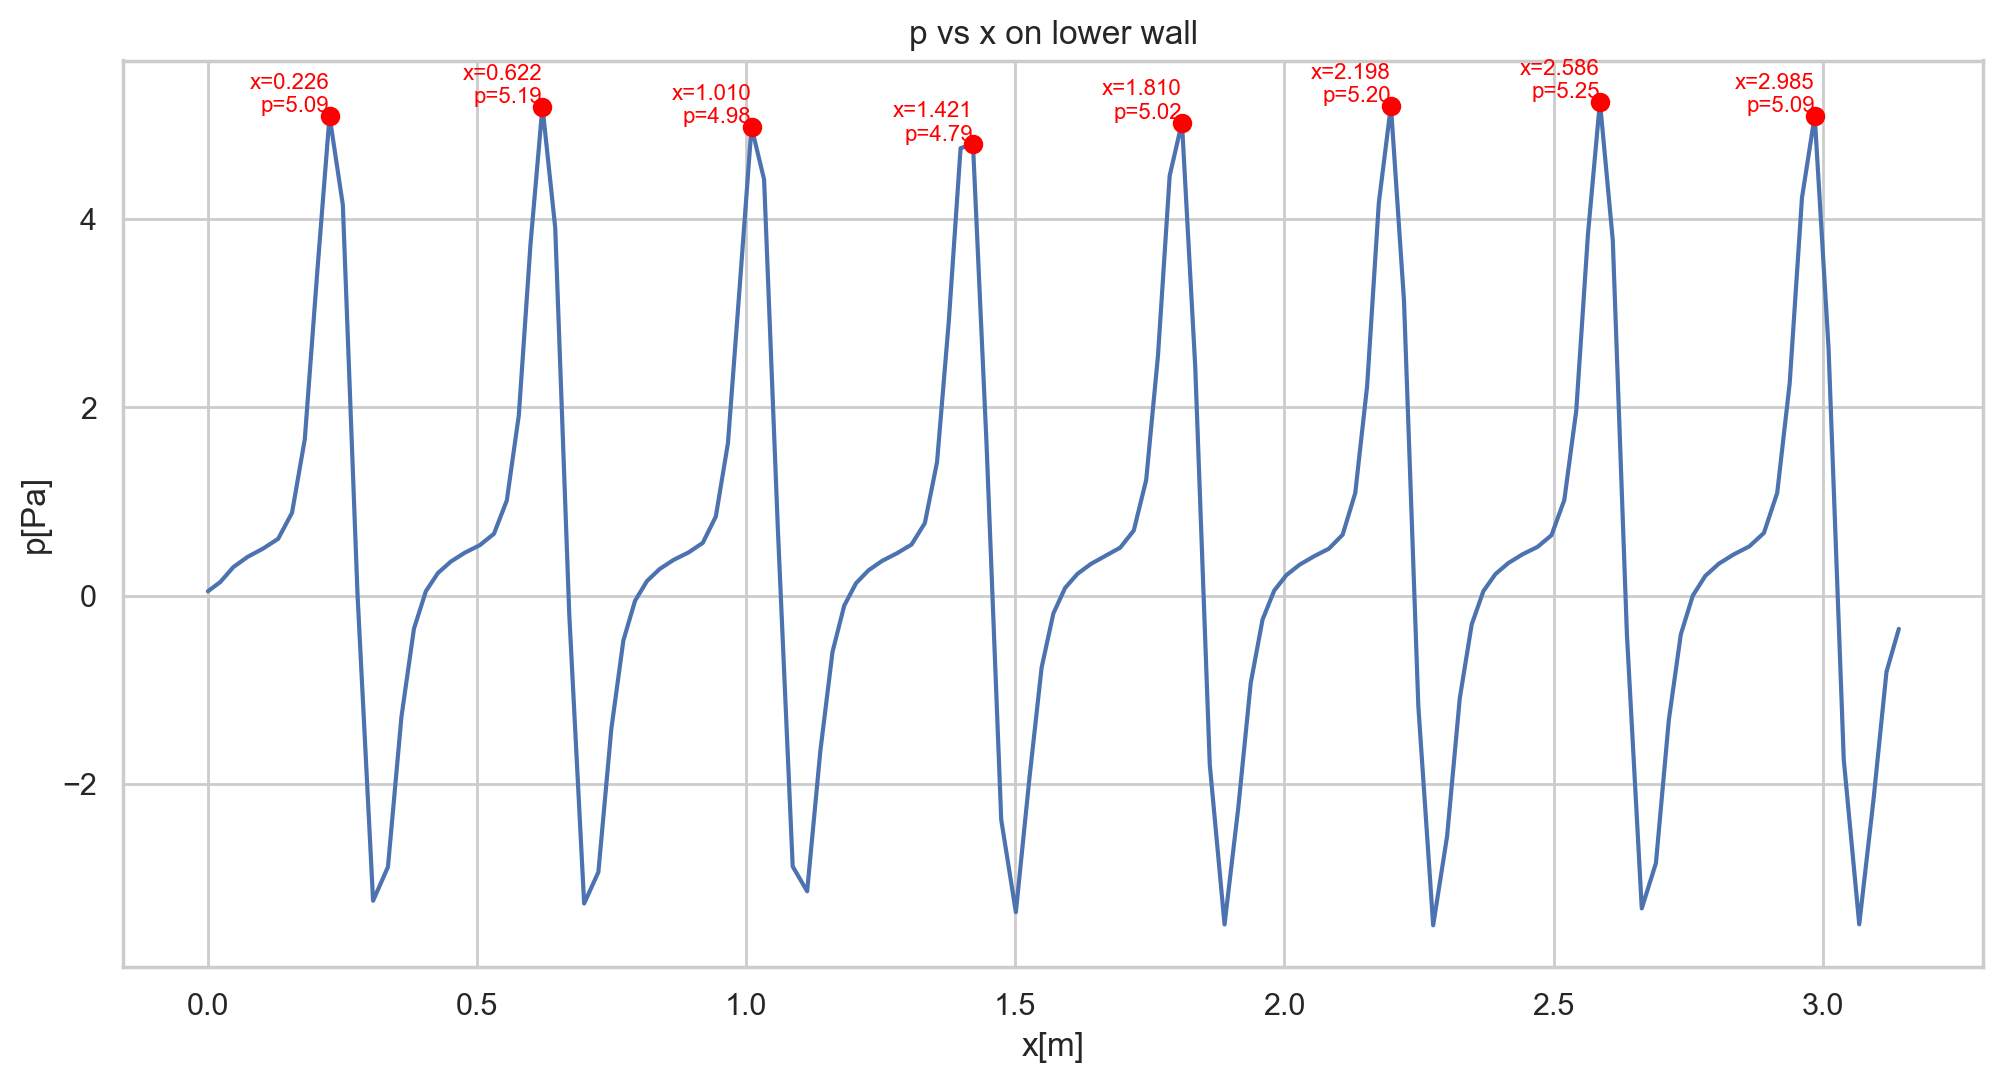

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6),dpi=200)

#find stagnation point
df_lower_wall = df.loc[df.groupby('x_rounded')['y'].idxmin()]
df_lower_wall = df_lower_wall.sort_values('x')

# Step 2: Plot full line
sns.lineplot(x='x', y='p', data=df_lower_wall)
plt.title('p vs x on lower wall')
plt.xlabel('x[m]')
plt.ylabel('p[Pa]')

# Step 3: Slice into periods and find max point per period
periods = {}
for i in range(1, periods_number + 1):  # i from 1 to N
    start = 1 + node_period * (i - 1)
    end = 1 + node_period * i
    periods[f'period{i}'] = df_lower_wall.iloc[start:end]

    period_df = periods[f'period{i}']
    max_idx = period_df['p'].idxmax()
    max_row = period_df.loc[max_idx]

    # Plot dot
    plt.scatter(max_row['x'], max_row['p'], color='red', zorder=5)

    # Annotate
    plt.text(max_row['x'], max_row['p'],
         f"x={max_row['x']:.3f}\np={max_row['p']:.2f}",
         color='red', fontsize=8,
         ha='right', va='bottom')
plt.grid(True)
plt.show()
   
                       